#Breve explicación de la Notebook

Se utilizó la arquitectura InceptionV3 sin utilizar Transfer Learning. Es decir, sin incluir pesos pre - entrenados. Esto ocasionó un estancamiento inicial importante en el entrenamiento del modelo. Por lo tanto, y teniendo en cuenta los resultados obtenidos mediante otros enfoques, se decidió dejar de lado este modelo y continuar haciendo pruebas con los que mejores resultados inciales obtuvieron. 

#Montaje e Importación de librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino

/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino


In [ ]:
import keras 
from keras.applications import InceptionV3
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model, load_model
from keras.applications.inception_v3 import preprocess_input

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt
from keras import applications

In [ ]:
#Curvas Auc - ROC y precision Recall
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#Modelo

##Inputs

In [ ]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 3 
BATCH_SIZE = 32 

In [ ]:
df_train=pd.read_excel("train0-7.xlsx")
df_test=pd.read_excel("test0-7.xlsx")

In [ ]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255,horizontal_flip=True,rotation_range=40)
dir = '/content/drive/My Drive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = train_datagen.flow_from_dataframe( #tomamos info de un df
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 13951 validated image filenames belonging to 3 classes.


In [ ]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3487 validated image filenames belonging to 3 classes.


##Model Definition & Training

In [ ]:
base_model = applications.InceptionV3(weights= None, 
                                include_top=False, 
                                input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)) #'imagenet'
base_model.trainable = False
add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(NUM_CLASSES, 
                    activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=1e-2, 
                                       momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
history = model.fit(train_batches, validation_data = valid_batches , epochs = 100,workers=10, callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),ReduceLROnPlateau(monitor='val_loss',factor = 0.1,patience=5,min_lr=0)], batch_size = BATCH_SIZE)

Epoch 1/100
436/436 [==============================] - 138s 304ms/step - loss: 0.8686 - accuracy: 0.6137 - val_loss: 0.8198 - val_accuracy: 0.6106
Epoch 2/100
436/436 [==============================] - 133s 299ms/step - loss: 0.8088 - accuracy: 0.6272 - val_loss: 0.8203 - val_accuracy: 0.6106
Epoch 3/100
436/436 [==============================] - 133s 300ms/step - loss: 0.7977 - accuracy: 0.6341 - val_loss: 0.8198 - val_accuracy: 0.6106
Epoch 4/100
436/436 [==============================] - 133s 301ms/step - loss: 0.8065 - accuracy: 0.6242 - val_loss: 0.8204 - val_accuracy: 0.6106
Epoch 5/100
436/436 [==============================] - 135s 300ms/step - loss: 0.8052 - accuracy: 0.6274 - val_loss: 0.8202 - val_accuracy: 0.6106
Epoch 6/100
436/436 [==============================] - 133s 300ms/step - loss: 0.8138 - accuracy: 0.6211 - val_loss: 0.8207 - val_accuracy: 0.6106
Epoch 7/100
436/436 [==============================] - 135s 300ms/step - loss: 0.8075 - accuracy: 0.6271 - val_loss: 0

In [ ]:
model.save('Inception2.h5')

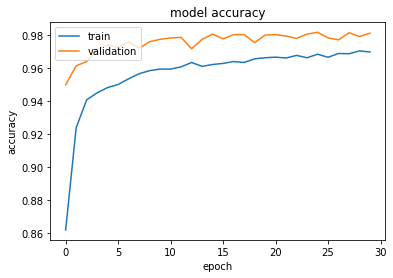

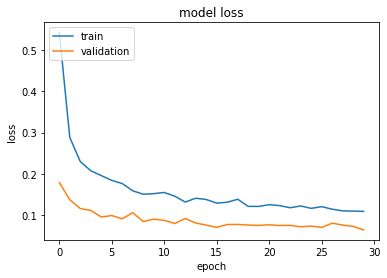

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Test

In [ ]:
dir = '/content/drive/My Drive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
test_datagen = ImageDataGenerator(rescale = 1./255)#Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"#, validate_filenames=False
    )

Found 4360 validated image filenames belonging to 3 classes.


In [ ]:
model = load_model('Inception1.h5')

In [ ]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

4360/4360 [==============================] - 1147s 261ms/step
(4360, 3)


In [ ]:
#Calculamos la matriz de predicciones
#result_test=model.predict(test_batches, verbose=1)
print ("Loss = " + str(result_test[0]))
print ("Test Accuracy = " + str(result_test[1]))

Loss = [1.4587310e-04 1.2253582e-06 9.9985290e-01]
Test Accuracy = [2.0136291e-03 7.0913382e-05 9.9791545e-01]


In [ ]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'PA'}

In [ ]:
#Obtenemos el índice de mayor score en cada fila (cada imagen)
preds = result_test.argmax(axis=-1)

In [ ]:
#Obtenemos el nombre de clase asignado a cada clase
preds_classes = [classes_dict[p] for p in preds]

In [ ]:
#Evaluar cuantas predicciones hay de cada clase
pd.Series(preds_classes).value_counts()

PA               2786
L                1441
AP_horizontal     133
dtype: int64

In [ ]:
import numpy as np
#Obtenemos el nombre de clase de la etiqueta verdadera (groun-truths)
gts = np.array([classes_dict[p] for p in test_batches.classes])

#Model Evaluation - Metrics

In [ ]:
#Evaluamos métricas de clasificación
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(gts,preds_classes))

               precision    recall  f1-score   support

AP_horizontal       0.95      0.58      0.72       217
            L       0.98      0.99      0.99      1427
           PA       0.97      0.99      0.98      2716

     accuracy                           0.97      4360
    macro avg       0.97      0.86      0.90      4360
 weighted avg       0.97      0.97      0.97      4360



In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera', fontsize=20)
    plt.xlabel('Predicción del modelo', fontsize=20)
    plt.show()

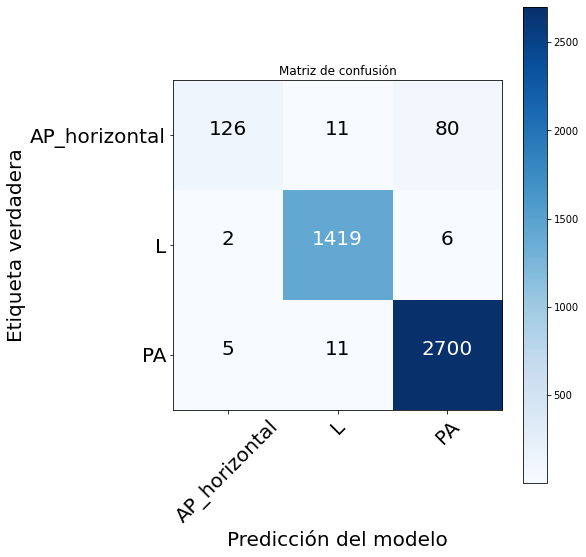

In [ ]:
confusionMatrix = confusion_matrix(gts,preds_classes)

plot_confusion_matrix(confusionMatrix,test_batches.class_indices.keys())

##ROC - AUC Curve, Precision - Recall Curve

In [ ]:
y_test = pd.get_dummies(gts).to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


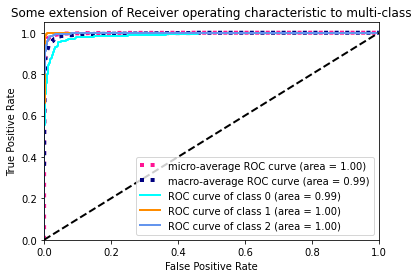

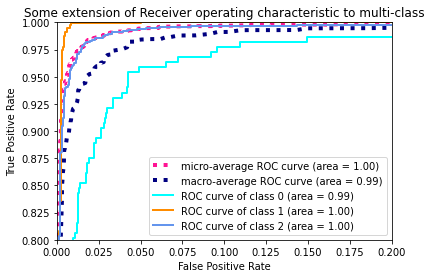

In [ ]:
y_score = result_test
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Y_test = pd.get_dummies(gts).to_numpy()
y_score = result_test

In [ ]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])


# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

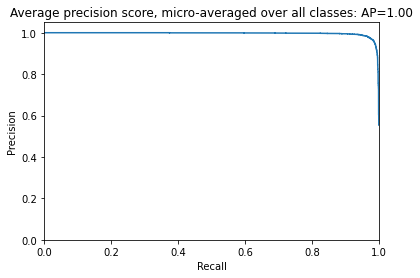

In [ ]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

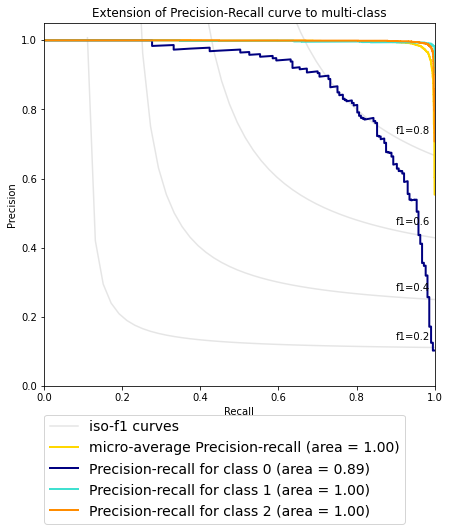

In [ ]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(NUM_CLASSES), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()